In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701688, 832)
(701688, 8)
validation
(129856, 832)
(129856, 8)
test
(60456, 832)
(60456, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:33 - loss: 2.3381 - STD: 0.1522 - MAE: 0.2206

 5/71 [=>............................] - ETA: 1s - loss: 1.7086 - STD: 0.1454 - MAE: 0.1822  

 8/71 [==>...........................] - ETA: 1s - loss: 1.6015 - STD: 0.1709 - MAE: 0.1673

12/71 [====>.........................] - ETA: 0s - loss: 1.5535 - STD: 0.1788 - MAE: 0.1615

15/71 [=====>........................] - ETA: 0s - loss: 1.5318 - STD: 0.1797 - MAE: 0.1599

18/71 [======>.......................] - ETA: 0s - loss: 1.5148 - STD: 0.1814 - MAE: 0.1584

21/71 [=======>......................] - ETA: 0s - loss: 1.5007 - STD: 0.1833 - MAE: 0.1570

25/71 [=========>....................] - ETA: 1s - loss: 1.4892 - STD: 0.1843 - MAE: 0.1560

28/71 [==========>...................] - ETA: 1s - loss: 1.4790 - STD: 0.1836 - MAE: 0.1559

31/71 [============>.................] - ETA: 1s - loss: 1.4713 - STD: 0.1826 - MAE: 0.1560

34/71 [=============>................] - ETA: 1s - loss: 1.4656 - STD: 0.1818 - MAE: 0.1561

37/71 [==============>...............] - ETA: 1s - loss: 1.4605 - STD: 0.1813 - MAE: 0.1560

40/71 [===============>..............] - ETA: 0s - loss: 1.4560 - STD: 0.1811 - MAE: 0.1560

43/71 [=================>............] - ETA: 0s - loss: 1.4513 - STD: 0.1808 - MAE: 0.1559

47/71 [==================>...........] - ETA: 0s - loss: 1.4469 - STD: 0.1806 - MAE: 0.1558

50/71 [====================>.........] - ETA: 0s - loss: 1.4444 - STD: 0.1806 - MAE: 0.1557

53/71 [=====================>........] - ETA: 0s - loss: 1.4418 - STD: 0.1805 - MAE: 0.1556

57/71 [=======================>......] - ETA: 0s - loss: 1.4389 - STD: 0.1805 - MAE: 0.1556

60/71 [========================>.....] - ETA: 0s - loss: 1.4372 - STD: 0.1804 - MAE: 0.1555

63/71 [=========================>....] - ETA: 0s - loss: 1.4353 - STD: 0.1804 - MAE: 0.1555

66/71 [==========================>...] - ETA: 0s - loss: 1.4337 - STD: 0.1803 - MAE: 0.1554

69/71 [============================>.] - ETA: 0s - loss: 1.4322 - STD: 0.1802 - MAE: 0.1554

71/71 [==============================] - 4s 37ms/step - loss: 1.4313 - STD: 0.1802 - MAE: 0.1554 - val_loss: 1.3313 - val_STD: 0.1785 - val_MAE: 0.1502


Epoch 2/10000


 1/71 [..............................] - ETA: 3s - loss: 1.3810 - STD: 0.1784 - MAE: 0.1538

 4/71 [>.............................] - ETA: 1s - loss: 1.4011 - STD: 0.1791 - MAE: 0.1547

 7/71 [=>............................] - ETA: 1s - loss: 1.3951 - STD: 0.1786 - MAE: 0.1545

10/71 [===>..........................] - ETA: 1s - loss: 1.3955 - STD: 0.1788 - MAE: 0.1545

13/71 [====>.........................] - ETA: 1s - loss: 1.3968 - STD: 0.1791 - MAE: 0.1545

16/71 [=====>........................] - ETA: 1s - loss: 1.3984 - STD: 0.1790 - MAE: 0.1546

19/71 [=======>......................] - ETA: 0s - loss: 1.3966 - STD: 0.1787 - MAE: 0.1546

22/71 [========>.....................] - ETA: 0s - loss: 1.3972 - STD: 0.1790 - MAE: 0.1545

25/71 [=========>....................] - ETA: 0s - loss: 1.3973 - STD: 0.1792 - MAE: 0.1544

28/71 [==========>...................] - ETA: 0s - loss: 1.3974 - STD: 0.1789 - MAE: 0.1545

32/71 [============>.................] - ETA: 0s - loss: 1.3961 - STD: 0.1790 - MAE: 0.1543

35/71 [=============>................] - ETA: 0s - loss: 1.3941 - STD: 0.1794 - MAE: 0.1541

39/71 [===============>..............] - ETA: 0s - loss: 1.3919 - STD: 0.1793 - MAE: 0.1540

42/71 [================>.............] - ETA: 0s - loss: 1.3916 - STD: 0.1794 - MAE: 0.1539

45/71 [==================>...........] - ETA: 0s - loss: 1.3905 - STD: 0.1793 - MAE: 0.1539

48/71 [===================>..........] - ETA: 0s - loss: 1.3893 - STD: 0.1793 - MAE: 0.1538

51/71 [====================>.........] - ETA: 0s - loss: 1.3883 - STD: 0.1794 - MAE: 0.1537

55/71 [======================>.......] - ETA: 0s - loss: 1.3856 - STD: 0.1796 - MAE: 0.1534

58/71 [=======================>......] - ETA: 0s - loss: 1.3835 - STD: 0.1798 - MAE: 0.1532

62/71 [=========================>....] - ETA: 0s - loss: 1.3811 - STD: 0.1800 - MAE: 0.1530

65/71 [==========================>...] - ETA: 0s - loss: 1.3792 - STD: 0.1803 - MAE: 0.1528

68/71 [===========================>..] - ETA: 0s - loss: 1.3772 - STD: 0.1804 - MAE: 0.1526

71/71 [==============================] - 2s 21ms/step - loss: 1.3755 - STD: 0.1807 - MAE: 0.1524 - val_loss: 1.2573 - val_STD: 0.1870 - val_MAE: 0.1416


Epoch 3/10000


 1/71 [..............................] - ETA: 3s - loss: 1.3387 - STD: 0.1844 - MAE: 0.1490

 4/71 [>.............................] - ETA: 1s - loss: 1.3271 - STD: 0.1890 - MAE: 0.1466

 7/71 [=>............................] - ETA: 1s - loss: 1.3267 - STD: 0.1870 - MAE: 0.1474

10/71 [===>..........................] - ETA: 1s - loss: 1.3259 - STD: 0.1871 - MAE: 0.1473

13/71 [====>.........................] - ETA: 1s - loss: 1.3230 - STD: 0.1883 - MAE: 0.1468

16/71 [=====>........................] - ETA: 0s - loss: 1.3194 - STD: 0.1875 - MAE: 0.1470

19/71 [=======>......................] - ETA: 0s - loss: 1.3165 - STD: 0.1880 - MAE: 0.1467

22/71 [========>.....................] - ETA: 0s - loss: 1.3147 - STD: 0.1888 - MAE: 0.1464

25/71 [=========>....................] - ETA: 0s - loss: 1.3119 - STD: 0.1886 - MAE: 0.1463

28/71 [==========>...................] - ETA: 0s - loss: 1.3085 - STD: 0.1887 - MAE: 0.1462

31/71 [============>.................] - ETA: 0s - loss: 1.3058 - STD: 0.1892 - MAE: 0.1460

34/71 [=============>................] - ETA: 0s - loss: 1.3018 - STD: 0.1893 - MAE: 0.1458

37/71 [==============>...............] - ETA: 0s - loss: 1.2986 - STD: 0.1895 - MAE: 0.1456

40/71 [===============>..............] - ETA: 0s - loss: 1.2954 - STD: 0.1896 - MAE: 0.1455

43/71 [=================>............] - ETA: 0s - loss: 1.2932 - STD: 0.1899 - MAE: 0.1453

46/71 [==================>...........] - ETA: 0s - loss: 1.2904 - STD: 0.1900 - MAE: 0.1452

49/71 [===================>..........] - ETA: 0s - loss: 1.2875 - STD: 0.1902 - MAE: 0.1451

52/71 [====================>.........] - ETA: 0s - loss: 1.2846 - STD: 0.1903 - MAE: 0.1450

55/71 [======================>.......] - ETA: 0s - loss: 1.2809 - STD: 0.1907 - MAE: 0.1447

58/71 [=======================>......] - ETA: 0s - loss: 1.2779 - STD: 0.1908 - MAE: 0.1446

61/71 [========================>.....] - ETA: 0s - loss: 1.2750 - STD: 0.1910 - MAE: 0.1444

65/71 [==========================>...] - ETA: 0s - loss: 1.2714 - STD: 0.1914 - MAE: 0.1441

68/71 [===========================>..] - ETA: 0s - loss: 1.2679 - STD: 0.1916 - MAE: 0.1439

71/71 [==============================] - 2s 22ms/step - loss: 1.2649 - STD: 0.1918 - MAE: 0.1438 - val_loss: 1.1084 - val_STD: 0.1918 - val_MAE: 0.1348


Epoch 4/10000


 1/71 [..............................] - ETA: 3s - loss: 1.1896 - STD: 0.1914 - MAE: 0.1416

 4/71 [>.............................] - ETA: 1s - loss: 1.1754 - STD: 0.1973 - MAE: 0.1388

 7/71 [=>............................] - ETA: 1s - loss: 1.1783 - STD: 0.1967 - MAE: 0.1393

10/71 [===>..........................] - ETA: 1s - loss: 1.1738 - STD: 0.1964 - MAE: 0.1393

13/71 [====>.........................] - ETA: 1s - loss: 1.1686 - STD: 0.1973 - MAE: 0.1387

16/71 [=====>........................] - ETA: 0s - loss: 1.1661 - STD: 0.1972 - MAE: 0.1387

20/71 [=======>......................] - ETA: 0s - loss: 1.1605 - STD: 0.1980 - MAE: 0.1382

23/71 [========>.....................] - ETA: 0s - loss: 1.1564 - STD: 0.1981 - MAE: 0.1380

26/71 [=========>....................] - ETA: 0s - loss: 1.1521 - STD: 0.1985 - MAE: 0.1378

29/71 [===========>..................] - ETA: 0s - loss: 1.1488 - STD: 0.1991 - MAE: 0.1374

32/71 [============>.................] - ETA: 0s - loss: 1.1450 - STD: 0.1997 - MAE: 0.1370

35/71 [=============>................] - ETA: 0s - loss: 1.1424 - STD: 0.1998 - MAE: 0.1369

38/71 [===============>..............] - ETA: 0s - loss: 1.1396 - STD: 0.2000 - MAE: 0.1367

41/71 [================>.............] - ETA: 0s - loss: 1.1371 - STD: 0.2003 - MAE: 0.1365

44/71 [=================>............] - ETA: 0s - loss: 1.1348 - STD: 0.2008 - MAE: 0.1362

47/71 [==================>...........] - ETA: 0s - loss: 1.1322 - STD: 0.2011 - MAE: 0.1360

51/71 [====================>.........] - ETA: 0s - loss: 1.1296 - STD: 0.2013 - MAE: 0.1359

54/71 [=====================>........] - ETA: 0s - loss: 1.1274 - STD: 0.2017 - MAE: 0.1356

57/71 [=======================>......] - ETA: 0s - loss: 1.1247 - STD: 0.2020 - MAE: 0.1354

60/71 [========================>.....] - ETA: 0s - loss: 1.1223 - STD: 0.2022 - MAE: 0.1352

63/71 [=========================>....] - ETA: 0s - loss: 1.1200 - STD: 0.2024 - MAE: 0.1351

66/71 [==========================>...] - ETA: 0s - loss: 1.1183 - STD: 0.2026 - MAE: 0.1349

69/71 [============================>.] - ETA: 0s - loss: 1.1166 - STD: 0.2027 - MAE: 0.1348

71/71 [==============================] - 2s 21ms/step - loss: 1.1156 - STD: 0.2029 - MAE: 0.1347 - val_loss: 1.0054 - val_STD: 0.2076 - val_MAE: 0.1247


Epoch 5/10000


 1/71 [..............................] - ETA: 3s - loss: 1.0866 - STD: 0.2082 - MAE: 0.1318

 5/71 [=>............................] - ETA: 1s - loss: 1.0770 - STD: 0.2088 - MAE: 0.1308

 8/71 [==>...........................] - ETA: 1s - loss: 1.0738 - STD: 0.2087 - MAE: 0.1308

11/71 [===>..........................] - ETA: 1s - loss: 1.0712 - STD: 0.2082 - MAE: 0.1309

15/71 [=====>........................] - ETA: 0s - loss: 1.0704 - STD: 0.2081 - MAE: 0.1310

18/71 [======>.......................] - ETA: 0s - loss: 1.0692 - STD: 0.2080 - MAE: 0.1310

21/71 [=======>......................] - ETA: 0s - loss: 1.0668 - STD: 0.2082 - MAE: 0.1308

24/71 [=========>....................] - ETA: 0s - loss: 1.0640 - STD: 0.2085 - MAE: 0.1306

28/71 [==========>...................] - ETA: 0s - loss: 1.0634 - STD: 0.2085 - MAE: 0.1306

32/71 [============>.................] - ETA: 0s - loss: 1.0613 - STD: 0.2090 - MAE: 0.1303

35/71 [=============>................] - ETA: 0s - loss: 1.0609 - STD: 0.2089 - MAE: 0.1303

39/71 [===============>..............] - ETA: 0s - loss: 1.0593 - STD: 0.2087 - MAE: 0.1303

43/71 [=================>............] - ETA: 0s - loss: 1.0574 - STD: 0.2089 - MAE: 0.1302

46/71 [==================>...........] - ETA: 0s - loss: 1.0561 - STD: 0.2089 - MAE: 0.1301

50/71 [====================>.........] - ETA: 0s - loss: 1.0544 - STD: 0.2092 - MAE: 0.1299

54/71 [=====================>........] - ETA: 0s - loss: 1.0527 - STD: 0.2093 - MAE: 0.1298

57/71 [=======================>......] - ETA: 0s - loss: 1.0514 - STD: 0.2093 - MAE: 0.1297

60/71 [========================>.....] - ETA: 0s - loss: 1.0498 - STD: 0.2095 - MAE: 0.1296

63/71 [=========================>....] - ETA: 0s - loss: 1.0481 - STD: 0.2097 - MAE: 0.1295

67/71 [===========================>..] - ETA: 0s - loss: 1.0456 - STD: 0.2098 - MAE: 0.1293

71/71 [==============================] - ETA: 0s - loss: 1.0425 - STD: 0.2100 - MAE: 0.1291

71/71 [==============================] - 2s 21ms/step - loss: 1.0425 - STD: 0.2100 - MAE: 0.1291 - val_loss: 0.9611 - val_STD: 0.2090 - val_MAE: 0.1227


Epoch 6/10000


 1/71 [..............................] - ETA: 3s - loss: 1.0001 - STD: 0.2130 - MAE: 0.1261

 4/71 [>.............................] - ETA: 1s - loss: 0.9945 - STD: 0.2145 - MAE: 0.1252

 7/71 [=>............................] - ETA: 1s - loss: 0.9917 - STD: 0.2142 - MAE: 0.1252

10/71 [===>..........................] - ETA: 1s - loss: 0.9896 - STD: 0.2140 - MAE: 0.1252

13/71 [====>.........................] - ETA: 1s - loss: 0.9876 - STD: 0.2145 - MAE: 0.1248

16/71 [=====>........................] - ETA: 0s - loss: 0.9867 - STD: 0.2148 - MAE: 0.1247

19/71 [=======>......................] - ETA: 0s - loss: 0.9854 - STD: 0.2152 - MAE: 0.1245

22/71 [========>.....................] - ETA: 0s - loss: 0.9844 - STD: 0.2151 - MAE: 0.1245

25/71 [=========>....................] - ETA: 0s - loss: 0.9823 - STD: 0.2153 - MAE: 0.1243

29/71 [===========>..................] - ETA: 0s - loss: 0.9803 - STD: 0.2155 - MAE: 0.1241

32/71 [============>.................] - ETA: 0s - loss: 0.9796 - STD: 0.2158 - MAE: 0.1239

36/71 [==============>...............] - ETA: 0s - loss: 0.9783 - STD: 0.2159 - MAE: 0.1238

39/71 [===============>..............] - ETA: 0s - loss: 0.9772 - STD: 0.2161 - MAE: 0.1237

43/71 [=================>............] - ETA: 0s - loss: 0.9757 - STD: 0.2162 - MAE: 0.1236

46/71 [==================>...........] - ETA: 0s - loss: 0.9749 - STD: 0.2163 - MAE: 0.1235

49/71 [===================>..........] - ETA: 0s - loss: 0.9745 - STD: 0.2165 - MAE: 0.1235

52/71 [====================>.........] - ETA: 0s - loss: 0.9734 - STD: 0.2166 - MAE: 0.1233

55/71 [======================>.......] - ETA: 0s - loss: 0.9726 - STD: 0.2167 - MAE: 0.1233

59/71 [=======================>......] - ETA: 0s - loss: 0.9714 - STD: 0.2169 - MAE: 0.1231

62/71 [=========================>....] - ETA: 0s - loss: 0.9705 - STD: 0.2170 - MAE: 0.1231

66/71 [==========================>...] - ETA: 0s - loss: 0.9697 - STD: 0.2171 - MAE: 0.1230

69/71 [============================>.] - ETA: 0s - loss: 0.9696 - STD: 0.2171 - MAE: 0.1230

71/71 [==============================] - 2s 21ms/step - loss: 0.9690 - STD: 0.2172 - MAE: 0.1229 - val_loss: 0.9221 - val_STD: 0.2194 - val_MAE: 0.1170


Epoch 7/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9437 - STD: 0.2229 - MAE: 0.1192

 4/71 [>.............................] - ETA: 1s - loss: 0.9476 - STD: 0.2204 - MAE: 0.1205

 7/71 [=>............................] - ETA: 1s - loss: 0.9488 - STD: 0.2199 - MAE: 0.1208

10/71 [===>..........................] - ETA: 1s - loss: 0.9481 - STD: 0.2198 - MAE: 0.1208

13/71 [====>.........................] - ETA: 1s - loss: 0.9497 - STD: 0.2198 - MAE: 0.1209

16/71 [=====>........................] - ETA: 0s - loss: 0.9484 - STD: 0.2200 - MAE: 0.1208

19/71 [=======>......................] - ETA: 0s - loss: 0.9496 - STD: 0.2198 - MAE: 0.1209

23/71 [========>.....................] - ETA: 0s - loss: 0.9491 - STD: 0.2203 - MAE: 0.1207

26/71 [=========>....................] - ETA: 0s - loss: 0.9477 - STD: 0.2203 - MAE: 0.1206

29/71 [===========>..................] - ETA: 0s - loss: 0.9457 - STD: 0.2204 - MAE: 0.1205

33/71 [============>.................] - ETA: 0s - loss: 0.9445 - STD: 0.2203 - MAE: 0.1205

36/71 [==============>...............] - ETA: 0s - loss: 0.9445 - STD: 0.2204 - MAE: 0.1204

39/71 [===============>..............] - ETA: 0s - loss: 0.9435 - STD: 0.2206 - MAE: 0.1203

42/71 [================>.............] - ETA: 0s - loss: 0.9435 - STD: 0.2206 - MAE: 0.1203

46/71 [==================>...........] - ETA: 0s - loss: 0.9422 - STD: 0.2206 - MAE: 0.1202

49/71 [===================>..........] - ETA: 0s - loss: 0.9411 - STD: 0.2208 - MAE: 0.1200

52/71 [====================>.........] - ETA: 0s - loss: 0.9406 - STD: 0.2209 - MAE: 0.1200

56/71 [======================>.......] - ETA: 0s - loss: 0.9403 - STD: 0.2209 - MAE: 0.1200

60/71 [========================>.....] - ETA: 0s - loss: 0.9395 - STD: 0.2209 - MAE: 0.1200

64/71 [==========================>...] - ETA: 0s - loss: 0.9392 - STD: 0.2211 - MAE: 0.1198

67/71 [===========================>..] - ETA: 0s - loss: 0.9386 - STD: 0.2212 - MAE: 0.1198

71/71 [==============================] - ETA: 0s - loss: 0.9381 - STD: 0.2212 - MAE: 0.1198

71/71 [==============================] - 1s 21ms/step - loss: 0.9381 - STD: 0.2212 - MAE: 0.1198 - val_loss: 0.9039 - val_STD: 0.2192 - val_MAE: 0.1165


Epoch 8/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9170 - STD: 0.2236 - MAE: 0.1175

 4/71 [>.............................] - ETA: 1s - loss: 0.9237 - STD: 0.2230 - MAE: 0.1183

 7/71 [=>............................] - ETA: 1s - loss: 0.9196 - STD: 0.2224 - MAE: 0.1183

10/71 [===>..........................] - ETA: 1s - loss: 0.9214 - STD: 0.2223 - MAE: 0.1185

13/71 [====>.........................] - ETA: 1s - loss: 0.9209 - STD: 0.2227 - MAE: 0.1183

16/71 [=====>........................] - ETA: 1s - loss: 0.9222 - STD: 0.2225 - MAE: 0.1185

19/71 [=======>......................] - ETA: 0s - loss: 0.9211 - STD: 0.2229 - MAE: 0.1182

22/71 [========>.....................] - ETA: 0s - loss: 0.9225 - STD: 0.2229 - MAE: 0.1183

25/71 [=========>....................] - ETA: 0s - loss: 0.9238 - STD: 0.2229 - MAE: 0.1184

28/71 [==========>...................] - ETA: 0s - loss: 0.9233 - STD: 0.2230 - MAE: 0.1183

31/71 [============>.................] - ETA: 0s - loss: 0.9221 - STD: 0.2230 - MAE: 0.1182

34/71 [=============>................] - ETA: 0s - loss: 0.9234 - STD: 0.2229 - MAE: 0.1184

37/71 [==============>...............] - ETA: 0s - loss: 0.9237 - STD: 0.2230 - MAE: 0.1183

40/71 [===============>..............] - ETA: 0s - loss: 0.9231 - STD: 0.2231 - MAE: 0.1182

43/71 [=================>............] - ETA: 0s - loss: 0.9234 - STD: 0.2231 - MAE: 0.1182

46/71 [==================>...........] - ETA: 0s - loss: 0.9223 - STD: 0.2232 - MAE: 0.1182

50/71 [====================>.........] - ETA: 0s - loss: 0.9220 - STD: 0.2231 - MAE: 0.1182

53/71 [=====================>........] - ETA: 0s - loss: 0.9212 - STD: 0.2232 - MAE: 0.1181

56/71 [======================>.......] - ETA: 0s - loss: 0.9205 - STD: 0.2232 - MAE: 0.1181

59/71 [=======================>......] - ETA: 0s - loss: 0.9197 - STD: 0.2234 - MAE: 0.1180

62/71 [=========================>....] - ETA: 0s - loss: 0.9197 - STD: 0.2233 - MAE: 0.1180

65/71 [==========================>...] - ETA: 0s - loss: 0.9190 - STD: 0.2233 - MAE: 0.1180

68/71 [===========================>..] - ETA: 0s - loss: 0.9184 - STD: 0.2234 - MAE: 0.1179

71/71 [==============================] - 2s 23ms/step - loss: 0.9186 - STD: 0.2235 - MAE: 0.1179 - val_loss: 0.8951 - val_STD: 0.2160 - val_MAE: 0.1179


Epoch 9/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8980 - STD: 0.2216 - MAE: 0.1180

 4/71 [>.............................] - ETA: 1s - loss: 0.9067 - STD: 0.2244 - MAE: 0.1170

 7/71 [=>............................] - ETA: 1s - loss: 0.9022 - STD: 0.2246 - MAE: 0.1166

11/71 [===>..........................] - ETA: 1s - loss: 0.9011 - STD: 0.2246 - MAE: 0.1165

14/71 [====>.........................] - ETA: 0s - loss: 0.9012 - STD: 0.2248 - MAE: 0.1165

18/71 [======>.......................] - ETA: 0s - loss: 0.9024 - STD: 0.2250 - MAE: 0.1164

22/71 [========>.....................] - ETA: 0s - loss: 0.9032 - STD: 0.2247 - MAE: 0.1166

26/71 [=========>....................] - ETA: 0s - loss: 0.9043 - STD: 0.2249 - MAE: 0.1166

29/71 [===========>..................] - ETA: 0s - loss: 0.9045 - STD: 0.2249 - MAE: 0.1167

32/71 [============>.................] - ETA: 0s - loss: 0.9040 - STD: 0.2249 - MAE: 0.1167

35/71 [=============>................] - ETA: 0s - loss: 0.9034 - STD: 0.2247 - MAE: 0.1167

38/71 [===============>..............] - ETA: 0s - loss: 0.9026 - STD: 0.2248 - MAE: 0.1166

41/71 [================>.............] - ETA: 0s - loss: 0.9018 - STD: 0.2249 - MAE: 0.1165

44/71 [=================>............] - ETA: 0s - loss: 0.9021 - STD: 0.2250 - MAE: 0.1165

47/71 [==================>...........] - ETA: 0s - loss: 0.9011 - STD: 0.2253 - MAE: 0.1163

50/71 [====================>.........] - ETA: 0s - loss: 0.9011 - STD: 0.2253 - MAE: 0.1163

53/71 [=====================>........] - ETA: 0s - loss: 0.9008 - STD: 0.2253 - MAE: 0.1163

57/71 [=======================>......] - ETA: 0s - loss: 0.9009 - STD: 0.2253 - MAE: 0.1163

60/71 [========================>.....] - ETA: 0s - loss: 0.9009 - STD: 0.2253 - MAE: 0.1163

63/71 [=========================>....] - ETA: 0s - loss: 0.9011 - STD: 0.2253 - MAE: 0.1163

67/71 [===========================>..] - ETA: 0s - loss: 0.9006 - STD: 0.2252 - MAE: 0.1163

71/71 [==============================] - ETA: 0s - loss: 0.9008 - STD: 0.2254 - MAE: 0.1162

71/71 [==============================] - 1s 21ms/step - loss: 0.9008 - STD: 0.2254 - MAE: 0.1162 - val_loss: 0.9267 - val_STD: 0.2079 - val_MAE: 0.1244


Epoch 10/10000


 1/71 [..............................] - ETA: 3s - loss: 0.9077 - STD: 0.2113 - MAE: 0.1236

 4/71 [>.............................] - ETA: 1s - loss: 0.9040 - STD: 0.2231 - MAE: 0.1177

 7/71 [=>............................] - ETA: 1s - loss: 0.9028 - STD: 0.2247 - MAE: 0.1168

10/71 [===>..........................] - ETA: 1s - loss: 0.9011 - STD: 0.2248 - MAE: 0.1166

13/71 [====>.........................] - ETA: 1s - loss: 0.8982 - STD: 0.2252 - MAE: 0.1162

16/71 [=====>........................] - ETA: 1s - loss: 0.8976 - STD: 0.2254 - MAE: 0.1161

19/71 [=======>......................] - ETA: 0s - loss: 0.8960 - STD: 0.2254 - MAE: 0.1160

22/71 [========>.....................] - ETA: 0s - loss: 0.8944 - STD: 0.2255 - MAE: 0.1159

25/71 [=========>....................] - ETA: 0s - loss: 0.8933 - STD: 0.2258 - MAE: 0.1157

29/71 [===========>..................] - ETA: 0s - loss: 0.8926 - STD: 0.2258 - MAE: 0.1157

32/71 [============>.................] - ETA: 0s - loss: 0.8930 - STD: 0.2260 - MAE: 0.1156

35/71 [=============>................] - ETA: 0s - loss: 0.8932 - STD: 0.2260 - MAE: 0.1156

38/71 [===============>..............] - ETA: 0s - loss: 0.8924 - STD: 0.2262 - MAE: 0.1155

42/71 [================>.............] - ETA: 0s - loss: 0.8915 - STD: 0.2264 - MAE: 0.1153

45/71 [==================>...........] - ETA: 0s - loss: 0.8910 - STD: 0.2263 - MAE: 0.1154

48/71 [===================>..........] - ETA: 0s - loss: 0.8905 - STD: 0.2263 - MAE: 0.1153

51/71 [====================>.........] - ETA: 0s - loss: 0.8900 - STD: 0.2265 - MAE: 0.1152

54/71 [=====================>........] - ETA: 0s - loss: 0.8899 - STD: 0.2266 - MAE: 0.1152

58/71 [=======================>......] - ETA: 0s - loss: 0.8889 - STD: 0.2265 - MAE: 0.1152

61/71 [========================>.....] - ETA: 0s - loss: 0.8880 - STD: 0.2266 - MAE: 0.1151

64/71 [==========================>...] - ETA: 0s - loss: 0.8875 - STD: 0.2266 - MAE: 0.1150

67/71 [===========================>..] - ETA: 0s - loss: 0.8872 - STD: 0.2267 - MAE: 0.1150

70/71 [============================>.] - ETA: 0s - loss: 0.8868 - STD: 0.2268 - MAE: 0.1149

71/71 [==============================] - 2s 21ms/step - loss: 0.8867 - STD: 0.2267 - MAE: 0.1149 - val_loss: 0.8602 - val_STD: 0.2288 - val_MAE: 0.1105


Epoch 11/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8705 - STD: 0.2352 - MAE: 0.1111

 4/71 [>.............................] - ETA: 1s - loss: 0.8879 - STD: 0.2301 - MAE: 0.1136

 7/71 [=>............................] - ETA: 1s - loss: 0.8812 - STD: 0.2286 - MAE: 0.1139

10/71 [===>..........................] - ETA: 1s - loss: 0.8819 - STD: 0.2278 - MAE: 0.1143

14/71 [====>.........................] - ETA: 0s - loss: 0.8830 - STD: 0.2286 - MAE: 0.1140

17/71 [======>.......................] - ETA: 0s - loss: 0.8807 - STD: 0.2286 - MAE: 0.1139

21/71 [=======>......................] - ETA: 0s - loss: 0.8804 - STD: 0.2285 - MAE: 0.1138

24/71 [=========>....................] - ETA: 0s - loss: 0.8805 - STD: 0.2284 - MAE: 0.1140

27/71 [==========>...................] - ETA: 0s - loss: 0.8809 - STD: 0.2282 - MAE: 0.1141

31/71 [============>.................] - ETA: 0s - loss: 0.8789 - STD: 0.2282 - MAE: 0.1139

35/71 [=============>................] - ETA: 0s - loss: 0.8780 - STD: 0.2282 - MAE: 0.1139

39/71 [===============>..............] - ETA: 0s - loss: 0.8780 - STD: 0.2282 - MAE: 0.1138

42/71 [================>.............] - ETA: 0s - loss: 0.8780 - STD: 0.2283 - MAE: 0.1138

46/71 [==================>...........] - ETA: 0s - loss: 0.8775 - STD: 0.2283 - MAE: 0.1138

49/71 [===================>..........] - ETA: 0s - loss: 0.8773 - STD: 0.2284 - MAE: 0.1138

52/71 [====================>.........] - ETA: 0s - loss: 0.8775 - STD: 0.2284 - MAE: 0.1138

55/71 [======================>.......] - ETA: 0s - loss: 0.8772 - STD: 0.2284 - MAE: 0.1137

58/71 [=======================>......] - ETA: 0s - loss: 0.8766 - STD: 0.2284 - MAE: 0.1137

61/71 [========================>.....] - ETA: 0s - loss: 0.8760 - STD: 0.2284 - MAE: 0.1136

65/71 [==========================>...] - ETA: 0s - loss: 0.8755 - STD: 0.2284 - MAE: 0.1136

69/71 [============================>.] - ETA: 0s - loss: 0.8748 - STD: 0.2285 - MAE: 0.1136

71/71 [==============================] - 1s 20ms/step - loss: 0.8747 - STD: 0.2285 - MAE: 0.1136 - val_loss: 0.8702 - val_STD: 0.2203 - val_MAE: 0.1153


Epoch 12/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8513 - STD: 0.2273 - MAE: 0.1126

 5/71 [=>............................] - ETA: 1s - loss: 0.8637 - STD: 0.2294 - MAE: 0.1125

 8/71 [==>...........................] - ETA: 1s - loss: 0.8641 - STD: 0.2295 - MAE: 0.1126

11/71 [===>..........................] - ETA: 1s - loss: 0.8640 - STD: 0.2300 - MAE: 0.1124

14/71 [====>.........................] - ETA: 0s - loss: 0.8664 - STD: 0.2302 - MAE: 0.1124

17/71 [======>.......................] - ETA: 0s - loss: 0.8682 - STD: 0.2299 - MAE: 0.1126

21/71 [=======>......................] - ETA: 0s - loss: 0.8712 - STD: 0.2297 - MAE: 0.1128

24/71 [=========>....................] - ETA: 0s - loss: 0.8732 - STD: 0.2296 - MAE: 0.1130

27/71 [==========>...................] - ETA: 0s - loss: 0.8727 - STD: 0.2295 - MAE: 0.1130

30/71 [===========>..................] - ETA: 0s - loss: 0.8722 - STD: 0.2292 - MAE: 0.1131

34/71 [=============>................] - ETA: 0s - loss: 0.8722 - STD: 0.2291 - MAE: 0.1132

38/71 [===============>..............] - ETA: 0s - loss: 0.8716 - STD: 0.2290 - MAE: 0.1132

41/71 [================>.............] - ETA: 0s - loss: 0.8697 - STD: 0.2291 - MAE: 0.1130

45/71 [==================>...........] - ETA: 0s - loss: 0.8689 - STD: 0.2292 - MAE: 0.1130

48/71 [===================>..........] - ETA: 0s - loss: 0.8687 - STD: 0.2293 - MAE: 0.1130

51/71 [====================>.........] - ETA: 0s - loss: 0.8687 - STD: 0.2293 - MAE: 0.1130

54/71 [=====================>........] - ETA: 0s - loss: 0.8682 - STD: 0.2293 - MAE: 0.1129

57/71 [=======================>......] - ETA: 0s - loss: 0.8679 - STD: 0.2293 - MAE: 0.1129

60/71 [========================>.....] - ETA: 0s - loss: 0.8675 - STD: 0.2294 - MAE: 0.1129

64/71 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2294 - MAE: 0.1128

67/71 [===========================>..] - ETA: 0s - loss: 0.8668 - STD: 0.2294 - MAE: 0.1128

71/71 [==============================] - ETA: 0s - loss: 0.8668 - STD: 0.2295 - MAE: 0.1127

71/71 [==============================] - 1s 20ms/step - loss: 0.8668 - STD: 0.2295 - MAE: 0.1127 - val_loss: 0.8843 - val_STD: 0.2159 - val_MAE: 0.1183


Epoch 13/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8579 - STD: 0.2214 - MAE: 0.1158

 4/71 [>.............................] - ETA: 1s - loss: 0.8536 - STD: 0.2284 - MAE: 0.1126

 7/71 [=>............................] - ETA: 1s - loss: 0.8541 - STD: 0.2295 - MAE: 0.1120

10/71 [===>..........................] - ETA: 1s - loss: 0.8539 - STD: 0.2298 - MAE: 0.1119

14/71 [====>.........................] - ETA: 1s - loss: 0.8538 - STD: 0.2299 - MAE: 0.1119

17/71 [======>.......................] - ETA: 0s - loss: 0.8538 - STD: 0.2301 - MAE: 0.1117

20/71 [=======>......................] - ETA: 0s - loss: 0.8543 - STD: 0.2302 - MAE: 0.1117

24/71 [=========>....................] - ETA: 0s - loss: 0.8555 - STD: 0.2301 - MAE: 0.1118

27/71 [==========>...................] - ETA: 0s - loss: 0.8552 - STD: 0.2303 - MAE: 0.1117

30/71 [===========>..................] - ETA: 0s - loss: 0.8548 - STD: 0.2303 - MAE: 0.1117

33/71 [============>.................] - ETA: 0s - loss: 0.8559 - STD: 0.2302 - MAE: 0.1118

36/71 [==============>...............] - ETA: 0s - loss: 0.8557 - STD: 0.2302 - MAE: 0.1118

39/71 [===============>..............] - ETA: 0s - loss: 0.8574 - STD: 0.2304 - MAE: 0.1118

42/71 [================>.............] - ETA: 0s - loss: 0.8581 - STD: 0.2305 - MAE: 0.1118

45/71 [==================>...........] - ETA: 0s - loss: 0.8589 - STD: 0.2304 - MAE: 0.1119

48/71 [===================>..........] - ETA: 0s - loss: 0.8588 - STD: 0.2303 - MAE: 0.1119

52/71 [====================>.........] - ETA: 0s - loss: 0.8590 - STD: 0.2303 - MAE: 0.1119

55/71 [======================>.......] - ETA: 0s - loss: 0.8586 - STD: 0.2303 - MAE: 0.1119

58/71 [=======================>......] - ETA: 0s - loss: 0.8578 - STD: 0.2304 - MAE: 0.1119

61/71 [========================>.....] - ETA: 0s - loss: 0.8573 - STD: 0.2304 - MAE: 0.1118

65/71 [==========================>...] - ETA: 0s - loss: 0.8569 - STD: 0.2304 - MAE: 0.1118

69/71 [============================>.] - ETA: 0s - loss: 0.8562 - STD: 0.2305 - MAE: 0.1118

71/71 [==============================] - 1s 21ms/step - loss: 0.8562 - STD: 0.2304 - MAE: 0.1118 - val_loss: 0.8629 - val_STD: 0.2275 - val_MAE: 0.1114


Epoch 14/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8462 - STD: 0.2347 - MAE: 0.1090

 4/71 [>.............................] - ETA: 1s - loss: 0.8569 - STD: 0.2316 - MAE: 0.1111

 7/71 [=>............................] - ETA: 1s - loss: 0.8519 - STD: 0.2316 - MAE: 0.1108

10/71 [===>..........................] - ETA: 1s - loss: 0.8525 - STD: 0.2313 - MAE: 0.1111

14/71 [====>.........................] - ETA: 0s - loss: 0.8511 - STD: 0.2312 - MAE: 0.1112

17/71 [======>.......................] - ETA: 0s - loss: 0.8501 - STD: 0.2312 - MAE: 0.1111

20/71 [=======>......................] - ETA: 0s - loss: 0.8507 - STD: 0.2314 - MAE: 0.1111

24/71 [=========>....................] - ETA: 0s - loss: 0.8509 - STD: 0.2311 - MAE: 0.1112

27/71 [==========>...................] - ETA: 0s - loss: 0.8506 - STD: 0.2315 - MAE: 0.1110

31/71 [============>.................] - ETA: 0s - loss: 0.8522 - STD: 0.2312 - MAE: 0.1112

35/71 [=============>................] - ETA: 0s - loss: 0.8537 - STD: 0.2312 - MAE: 0.1113

39/71 [===============>..............] - ETA: 0s - loss: 0.8542 - STD: 0.2311 - MAE: 0.1114

42/71 [================>.............] - ETA: 0s - loss: 0.8540 - STD: 0.2313 - MAE: 0.1113

45/71 [==================>...........] - ETA: 0s - loss: 0.8553 - STD: 0.2313 - MAE: 0.1114

49/71 [===================>..........] - ETA: 0s - loss: 0.8550 - STD: 0.2313 - MAE: 0.1114

53/71 [=====================>........] - ETA: 0s - loss: 0.8542 - STD: 0.2313 - MAE: 0.1113

56/71 [======================>.......] - ETA: 0s - loss: 0.8539 - STD: 0.2312 - MAE: 0.1113

60/71 [========================>.....] - ETA: 0s - loss: 0.8537 - STD: 0.2313 - MAE: 0.1113

64/71 [==========================>...] - ETA: 0s - loss: 0.8534 - STD: 0.2312 - MAE: 0.1113

67/71 [===========================>..] - ETA: 0s - loss: 0.8527 - STD: 0.2312 - MAE: 0.1113

71/71 [==============================] - ETA: 0s - loss: 0.8524 - STD: 0.2313 - MAE: 0.1112

71/71 [==============================] - 1s 21ms/step - loss: 0.8524 - STD: 0.2313 - MAE: 0.1112 - val_loss: 0.8638 - val_STD: 0.2233 - val_MAE: 0.1138


Epoch 15/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8463 - STD: 0.2297 - MAE: 0.1117

 4/71 [>.............................] - ETA: 1s - loss: 0.8435 - STD: 0.2306 - MAE: 0.1110

 8/71 [==>...........................] - ETA: 1s - loss: 0.8499 - STD: 0.2320 - MAE: 0.1106

11/71 [===>..........................] - ETA: 1s - loss: 0.8511 - STD: 0.2324 - MAE: 0.1104

14/71 [====>.........................] - ETA: 0s - loss: 0.8525 - STD: 0.2326 - MAE: 0.1105

17/71 [======>.......................] - ETA: 0s - loss: 0.8539 - STD: 0.2325 - MAE: 0.1106

20/71 [=======>......................] - ETA: 0s - loss: 0.8552 - STD: 0.2321 - MAE: 0.1110

23/71 [========>.....................] - ETA: 0s - loss: 0.8536 - STD: 0.2320 - MAE: 0.1109

26/71 [=========>....................] - ETA: 0s - loss: 0.8521 - STD: 0.2320 - MAE: 0.1109

29/71 [===========>..................] - ETA: 0s - loss: 0.8520 - STD: 0.2318 - MAE: 0.1109

33/71 [============>.................] - ETA: 0s - loss: 0.8512 - STD: 0.2317 - MAE: 0.1109

37/71 [==============>...............] - ETA: 0s - loss: 0.8502 - STD: 0.2317 - MAE: 0.1109

40/71 [===============>..............] - ETA: 0s - loss: 0.8496 - STD: 0.2317 - MAE: 0.1108

43/71 [=================>............] - ETA: 0s - loss: 0.8487 - STD: 0.2317 - MAE: 0.1108

46/71 [==================>...........] - ETA: 0s - loss: 0.8483 - STD: 0.2318 - MAE: 0.1108

49/71 [===================>..........] - ETA: 0s - loss: 0.8475 - STD: 0.2318 - MAE: 0.1107

52/71 [====================>.........] - ETA: 0s - loss: 0.8472 - STD: 0.2318 - MAE: 0.1107

55/71 [======================>.......] - ETA: 0s - loss: 0.8459 - STD: 0.2319 - MAE: 0.1106

59/71 [=======================>......] - ETA: 0s - loss: 0.8455 - STD: 0.2319 - MAE: 0.1105

62/71 [=========================>....] - ETA: 0s - loss: 0.8446 - STD: 0.2320 - MAE: 0.1105

66/71 [==========================>...] - ETA: 0s - loss: 0.8439 - STD: 0.2320 - MAE: 0.1104

69/71 [============================>.] - ETA: 0s - loss: 0.8433 - STD: 0.2321 - MAE: 0.1103

71/71 [==============================] - 1s 20ms/step - loss: 0.8429 - STD: 0.2321 - MAE: 0.1103 - val_loss: 0.8531 - val_STD: 0.2257 - val_MAE: 0.1122


Epoch 16/10000


 1/71 [..............................] - ETA: 1s - loss: 0.8256 - STD: 0.2341 - MAE: 0.1082

 4/71 [>.............................] - ETA: 1s - loss: 0.8400 - STD: 0.2336 - MAE: 0.1093

 7/71 [=>............................] - ETA: 1s - loss: 0.8362 - STD: 0.2333 - MAE: 0.1093

11/71 [===>..........................] - ETA: 1s - loss: 0.8382 - STD: 0.2330 - MAE: 0.1096

15/71 [=====>........................] - ETA: 0s - loss: 0.8363 - STD: 0.2327 - MAE: 0.1097

18/71 [======>.......................] - ETA: 0s - loss: 0.8347 - STD: 0.2329 - MAE: 0.1095

21/71 [=======>......................] - ETA: 0s - loss: 0.8344 - STD: 0.2331 - MAE: 0.1094

24/71 [=========>....................] - ETA: 0s - loss: 0.8336 - STD: 0.2331 - MAE: 0.1094

27/71 [==========>...................] - ETA: 0s - loss: 0.8331 - STD: 0.2332 - MAE: 0.1093

31/71 [============>.................] - ETA: 0s - loss: 0.8338 - STD: 0.2332 - MAE: 0.1093

34/71 [=============>................] - ETA: 0s - loss: 0.8341 - STD: 0.2331 - MAE: 0.1094

38/71 [===============>..............] - ETA: 0s - loss: 0.8335 - STD: 0.2332 - MAE: 0.1093

41/71 [================>.............] - ETA: 0s - loss: 0.8342 - STD: 0.2332 - MAE: 0.1094

44/71 [=================>............] - ETA: 0s - loss: 0.8339 - STD: 0.2331 - MAE: 0.1094

48/71 [===================>..........] - ETA: 0s - loss: 0.8334 - STD: 0.2331 - MAE: 0.1094

51/71 [====================>.........] - ETA: 0s - loss: 0.8336 - STD: 0.2331 - MAE: 0.1094

54/71 [=====================>........] - ETA: 0s - loss: 0.8338 - STD: 0.2331 - MAE: 0.1094

58/71 [=======================>......] - ETA: 0s - loss: 0.8344 - STD: 0.2332 - MAE: 0.1094

61/71 [========================>.....] - ETA: 0s - loss: 0.8338 - STD: 0.2333 - MAE: 0.1093

64/71 [==========================>...] - ETA: 0s - loss: 0.8339 - STD: 0.2332 - MAE: 0.1093

68/71 [===========================>..] - ETA: 0s - loss: 0.8349 - STD: 0.2332 - MAE: 0.1094

71/71 [==============================] - 1s 20ms/step - loss: 0.8349 - STD: 0.2333 - MAE: 0.1094 - val_loss: 0.8586 - val_STD: 0.2238 - val_MAE: 0.1136


Epoch 17/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8299 - STD: 0.2314 - MAE: 0.1099

 4/71 [>.............................] - ETA: 1s - loss: 0.8444 - STD: 0.2328 - MAE: 0.1101

 7/71 [=>............................] - ETA: 1s - loss: 0.8444 - STD: 0.2332 - MAE: 0.1098

10/71 [===>..........................] - ETA: 1s - loss: 0.8468 - STD: 0.2333 - MAE: 0.1099

13/71 [====>.........................] - ETA: 1s - loss: 0.8462 - STD: 0.2332 - MAE: 0.1099

16/71 [=====>........................] - ETA: 0s - loss: 0.8445 - STD: 0.2332 - MAE: 0.1098

19/71 [=======>......................] - ETA: 0s - loss: 0.8434 - STD: 0.2332 - MAE: 0.1098

22/71 [========>.....................] - ETA: 0s - loss: 0.8418 - STD: 0.2330 - MAE: 0.1098

25/71 [=========>....................] - ETA: 0s - loss: 0.8406 - STD: 0.2331 - MAE: 0.1097

28/71 [==========>...................] - ETA: 0s - loss: 0.8385 - STD: 0.2332 - MAE: 0.1096

31/71 [============>.................] - ETA: 0s - loss: 0.8384 - STD: 0.2332 - MAE: 0.1096

34/71 [=============>................] - ETA: 0s - loss: 0.8376 - STD: 0.2332 - MAE: 0.1095

38/71 [===============>..............] - ETA: 0s - loss: 0.8365 - STD: 0.2331 - MAE: 0.1095

41/71 [================>.............] - ETA: 0s - loss: 0.8355 - STD: 0.2332 - MAE: 0.1094

44/71 [=================>............] - ETA: 0s - loss: 0.8355 - STD: 0.2333 - MAE: 0.1094

47/71 [==================>...........] - ETA: 0s - loss: 0.8370 - STD: 0.2333 - MAE: 0.1095

50/71 [====================>.........] - ETA: 0s - loss: 0.8373 - STD: 0.2335 - MAE: 0.1094

53/71 [=====================>........] - ETA: 0s - loss: 0.8378 - STD: 0.2335 - MAE: 0.1094

56/71 [======================>.......] - ETA: 0s - loss: 0.8380 - STD: 0.2335 - MAE: 0.1095

59/71 [=======================>......] - ETA: 0s - loss: 0.8376 - STD: 0.2332 - MAE: 0.1096

62/71 [=========================>....] - ETA: 0s - loss: 0.8370 - STD: 0.2332 - MAE: 0.1095

65/71 [==========================>...] - ETA: 0s - loss: 0.8362 - STD: 0.2333 - MAE: 0.1095

68/71 [===========================>..] - ETA: 0s - loss: 0.8358 - STD: 0.2333 - MAE: 0.1095

71/71 [==============================] - ETA: 0s - loss: 0.8352 - STD: 0.2333 - MAE: 0.1094

71/71 [==============================] - 2s 21ms/step - loss: 0.8352 - STD: 0.2333 - MAE: 0.1094 - val_loss: 0.8492 - val_STD: 0.2315 - val_MAE: 0.1093


Epoch 18/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8125 - STD: 0.2379 - MAE: 0.1065

 4/71 [>.............................] - ETA: 1s - loss: 0.8122 - STD: 0.2354 - MAE: 0.1071

 7/71 [=>............................] - ETA: 1s - loss: 0.8158 - STD: 0.2352 - MAE: 0.1073

10/71 [===>..........................] - ETA: 1s - loss: 0.8158 - STD: 0.2351 - MAE: 0.1074

14/71 [====>.........................] - ETA: 0s - loss: 0.8170 - STD: 0.2348 - MAE: 0.1079

17/71 [======>.......................] - ETA: 0s - loss: 0.8164 - STD: 0.2348 - MAE: 0.1079

20/71 [=======>......................] - ETA: 0s - loss: 0.8164 - STD: 0.2347 - MAE: 0.1079

23/71 [========>.....................] - ETA: 0s - loss: 0.8184 - STD: 0.2346 - MAE: 0.1080

26/71 [=========>....................] - ETA: 0s - loss: 0.8196 - STD: 0.2346 - MAE: 0.1081

29/71 [===========>..................] - ETA: 0s - loss: 0.8209 - STD: 0.2348 - MAE: 0.1080

32/71 [============>.................] - ETA: 0s - loss: 0.8209 - STD: 0.2348 - MAE: 0.1080

35/71 [=============>................] - ETA: 0s - loss: 0.8212 - STD: 0.2346 - MAE: 0.1081

38/71 [===============>..............] - ETA: 0s - loss: 0.8211 - STD: 0.2345 - MAE: 0.1081

41/71 [================>.............] - ETA: 0s - loss: 0.8215 - STD: 0.2346 - MAE: 0.1081

44/71 [=================>............] - ETA: 0s - loss: 0.8218 - STD: 0.2346 - MAE: 0.1082

47/71 [==================>...........] - ETA: 0s - loss: 0.8213 - STD: 0.2346 - MAE: 0.1081

50/71 [====================>.........] - ETA: 0s - loss: 0.8215 - STD: 0.2345 - MAE: 0.1082

53/71 [=====================>........] - ETA: 0s - loss: 0.8214 - STD: 0.2344 - MAE: 0.1082

56/71 [======================>.......] - ETA: 0s - loss: 0.8214 - STD: 0.2344 - MAE: 0.1082

59/71 [=======================>......] - ETA: 0s - loss: 0.8207 - STD: 0.2345 - MAE: 0.1081

63/71 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2346 - MAE: 0.1081

66/71 [==========================>...] - ETA: 0s - loss: 0.8212 - STD: 0.2346 - MAE: 0.1081

70/71 [============================>.] - ETA: 0s - loss: 0.8221 - STD: 0.2347 - MAE: 0.1081

71/71 [==============================] - 2s 21ms/step - loss: 0.8222 - STD: 0.2345 - MAE: 0.1082 - val_loss: 0.8489 - val_STD: 0.2306 - val_MAE: 0.1097


Epoch 19/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8338 - STD: 0.2376 - MAE: 0.1077

 4/71 [>.............................] - ETA: 1s - loss: 0.8158 - STD: 0.2360 - MAE: 0.1073

 7/71 [=>............................] - ETA: 1s - loss: 0.8195 - STD: 0.2347 - MAE: 0.1079

10/71 [===>..........................] - ETA: 1s - loss: 0.8210 - STD: 0.2348 - MAE: 0.1080

13/71 [====>.........................] - ETA: 1s - loss: 0.8198 - STD: 0.2348 - MAE: 0.1080

17/71 [======>.......................] - ETA: 0s - loss: 0.8215 - STD: 0.2347 - MAE: 0.1081

21/71 [=======>......................] - ETA: 0s - loss: 0.8231 - STD: 0.2350 - MAE: 0.1080

25/71 [=========>....................] - ETA: 0s - loss: 0.8239 - STD: 0.2347 - MAE: 0.1082

28/71 [==========>...................] - ETA: 0s - loss: 0.8234 - STD: 0.2347 - MAE: 0.1081

31/71 [============>.................] - ETA: 0s - loss: 0.8244 - STD: 0.2350 - MAE: 0.1081

34/71 [=============>................] - ETA: 0s - loss: 0.8269 - STD: 0.2350 - MAE: 0.1082

38/71 [===============>..............] - ETA: 0s - loss: 0.8277 - STD: 0.2347 - MAE: 0.1084

41/71 [================>.............] - ETA: 0s - loss: 0.8275 - STD: 0.2347 - MAE: 0.1084

44/71 [=================>............] - ETA: 0s - loss: 0.8262 - STD: 0.2346 - MAE: 0.1084

47/71 [==================>...........] - ETA: 0s - loss: 0.8253 - STD: 0.2346 - MAE: 0.1083

50/71 [====================>.........] - ETA: 0s - loss: 0.8250 - STD: 0.2345 - MAE: 0.1083

54/71 [=====================>........] - ETA: 0s - loss: 0.8237 - STD: 0.2345 - MAE: 0.1083

58/71 [=======================>......] - ETA: 0s - loss: 0.8236 - STD: 0.2347 - MAE: 0.1082

61/71 [========================>.....] - ETA: 0s - loss: 0.8228 - STD: 0.2347 - MAE: 0.1081

65/71 [==========================>...] - ETA: 0s - loss: 0.8229 - STD: 0.2347 - MAE: 0.1081

68/71 [===========================>..] - ETA: 0s - loss: 0.8224 - STD: 0.2348 - MAE: 0.1080

71/71 [==============================] - 1s 21ms/step - loss: 0.8219 - STD: 0.2348 - MAE: 0.1080 - val_loss: 0.8571 - val_STD: 0.2295 - val_MAE: 0.1108


Epoch 20/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8212 - STD: 0.2368 - MAE: 0.1069

 4/71 [>.............................] - ETA: 1s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1079

 7/71 [=>............................] - ETA: 1s - loss: 0.8195 - STD: 0.2349 - MAE: 0.1078

10/71 [===>..........................] - ETA: 1s - loss: 0.8180 - STD: 0.2348 - MAE: 0.1079

13/71 [====>.........................] - ETA: 1s - loss: 0.8131 - STD: 0.2349 - MAE: 0.1075

16/71 [=====>........................] - ETA: 0s - loss: 0.8113 - STD: 0.2350 - MAE: 0.1074

19/71 [=======>......................] - ETA: 0s - loss: 0.8111 - STD: 0.2350 - MAE: 0.1074

23/71 [========>.....................] - ETA: 0s - loss: 0.8136 - STD: 0.2356 - MAE: 0.1073

27/71 [==========>...................] - ETA: 0s - loss: 0.8144 - STD: 0.2356 - MAE: 0.1073

30/71 [===========>..................] - ETA: 0s - loss: 0.8155 - STD: 0.2356 - MAE: 0.1073

34/71 [=============>................] - ETA: 0s - loss: 0.8152 - STD: 0.2355 - MAE: 0.1074

37/71 [==============>...............] - ETA: 0s - loss: 0.8153 - STD: 0.2354 - MAE: 0.1074

41/71 [================>.............] - ETA: 0s - loss: 0.8148 - STD: 0.2354 - MAE: 0.1073

44/71 [=================>............] - ETA: 0s - loss: 0.8154 - STD: 0.2354 - MAE: 0.1074

48/71 [===================>..........] - ETA: 0s - loss: 0.8152 - STD: 0.2355 - MAE: 0.1073

51/71 [====================>.........] - ETA: 0s - loss: 0.8146 - STD: 0.2355 - MAE: 0.1073

54/71 [=====================>........] - ETA: 0s - loss: 0.8142 - STD: 0.2355 - MAE: 0.1072

57/71 [=======================>......] - ETA: 0s - loss: 0.8143 - STD: 0.2355 - MAE: 0.1072

60/71 [========================>.....] - ETA: 0s - loss: 0.8141 - STD: 0.2355 - MAE: 0.1073

63/71 [=========================>....] - ETA: 0s - loss: 0.8143 - STD: 0.2356 - MAE: 0.1072

66/71 [==========================>...] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1072

70/71 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2355 - MAE: 0.1073

71/71 [==============================] - 1s 20ms/step - loss: 0.8144 - STD: 0.2356 - MAE: 0.1072 - val_loss: 0.8558 - val_STD: 0.2322 - val_MAE: 0.1094


Epoch 21/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8189 - STD: 0.2397 - MAE: 0.1058

 4/71 [>.............................] - ETA: 1s - loss: 0.8132 - STD: 0.2355 - MAE: 0.1072

 7/71 [=>............................] - ETA: 1s - loss: 0.8103 - STD: 0.2355 - MAE: 0.1071

10/71 [===>..........................] - ETA: 1s - loss: 0.8122 - STD: 0.2354 - MAE: 0.1072

13/71 [====>.........................] - ETA: 1s - loss: 0.8135 - STD: 0.2356 - MAE: 0.1073

16/71 [=====>........................] - ETA: 1s - loss: 0.8118 - STD: 0.2359 - MAE: 0.1070

19/71 [=======>......................] - ETA: 0s - loss: 0.8122 - STD: 0.2357 - MAE: 0.1071

22/71 [========>.....................] - ETA: 0s - loss: 0.8110 - STD: 0.2357 - MAE: 0.1071

25/71 [=========>....................] - ETA: 0s - loss: 0.8100 - STD: 0.2359 - MAE: 0.1069

28/71 [==========>...................] - ETA: 0s - loss: 0.8094 - STD: 0.2359 - MAE: 0.1068

31/71 [============>.................] - ETA: 0s - loss: 0.8086 - STD: 0.2360 - MAE: 0.1067

34/71 [=============>................] - ETA: 0s - loss: 0.8075 - STD: 0.2361 - MAE: 0.1066

38/71 [===============>..............] - ETA: 0s - loss: 0.8084 - STD: 0.2362 - MAE: 0.1066

42/71 [================>.............] - ETA: 0s - loss: 0.8088 - STD: 0.2359 - MAE: 0.1069

45/71 [==================>...........] - ETA: 0s - loss: 0.8092 - STD: 0.2360 - MAE: 0.1068

49/71 [===================>..........] - ETA: 0s - loss: 0.8094 - STD: 0.2360 - MAE: 0.1069

52/71 [====================>.........] - ETA: 0s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1068

55/71 [======================>.......] - ETA: 0s - loss: 0.8086 - STD: 0.2360 - MAE: 0.1068

59/71 [=======================>......] - ETA: 0s - loss: 0.8099 - STD: 0.2360 - MAE: 0.1069

63/71 [=========================>....] - ETA: 0s - loss: 0.8093 - STD: 0.2361 - MAE: 0.1068

66/71 [==========================>...] - ETA: 0s - loss: 0.8090 - STD: 0.2361 - MAE: 0.1068

70/71 [============================>.] - ETA: 0s - loss: 0.8099 - STD: 0.2361 - MAE: 0.1068

71/71 [==============================] - 2s 21ms/step - loss: 0.8100 - STD: 0.2361 - MAE: 0.1068 - val_loss: 0.8537 - val_STD: 0.2273 - val_MAE: 0.1119


Epoch 22/10000


 1/71 [..............................] - ETA: 3s - loss: 0.8024 - STD: 0.2338 - MAE: 0.1073

 5/71 [=>............................] - ETA: 0s - loss: 0.8142 - STD: 0.2361 - MAE: 0.1072

 8/71 [==>...........................] - ETA: 0s - loss: 0.8179 - STD: 0.2351 - MAE: 0.1078

11/71 [===>..........................] - ETA: 0s - loss: 0.8171 - STD: 0.2351 - MAE: 0.1078

14/71 [====>.........................] - ETA: 0s - loss: 0.8181 - STD: 0.2352 - MAE: 0.1077

18/71 [======>.......................] - ETA: 0s - loss: 0.8175 - STD: 0.2360 - MAE: 0.1074

21/71 [=======>......................] - ETA: 0s - loss: 0.8165 - STD: 0.2356 - MAE: 0.1075

24/71 [=========>....................] - ETA: 0s - loss: 0.8150 - STD: 0.2356 - MAE: 0.1074

28/71 [==========>...................] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1074

32/71 [============>.................] - ETA: 0s - loss: 0.8156 - STD: 0.2357 - MAE: 0.1074

35/71 [=============>................] - ETA: 0s - loss: 0.8152 - STD: 0.2355 - MAE: 0.1075

38/71 [===============>..............] - ETA: 0s - loss: 0.8155 - STD: 0.2355 - MAE: 0.1075

41/71 [================>.............] - ETA: 0s - loss: 0.8153 - STD: 0.2357 - MAE: 0.1074

45/71 [==================>...........] - ETA: 0s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1073

48/71 [===================>..........] - ETA: 0s - loss: 0.8145 - STD: 0.2357 - MAE: 0.1073

52/71 [====================>.........] - ETA: 0s - loss: 0.8131 - STD: 0.2357 - MAE: 0.1072

55/71 [======================>.......] - ETA: 0s - loss: 0.8121 - STD: 0.2359 - MAE: 0.1071

58/71 [=======================>......] - ETA: 0s - loss: 0.8114 - STD: 0.2358 - MAE: 0.1071

61/71 [========================>.....] - ETA: 0s - loss: 0.8105 - STD: 0.2359 - MAE: 0.1070

64/71 [==========================>...] - ETA: 0s - loss: 0.8093 - STD: 0.2360 - MAE: 0.1069

67/71 [===========================>..] - ETA: 0s - loss: 0.8088 - STD: 0.2360 - MAE: 0.1068

71/71 [==============================] - ETA: 0s - loss: 0.8087 - STD: 0.2362 - MAE: 0.1067

71/71 [==============================] - 1s 21ms/step - loss: 0.8087 - STD: 0.2362 - MAE: 0.1067 - val_loss: 0.9284 - val_STD: 0.2250 - val_MAE: 0.1178


Epoch 23/10000


 1/71 [..............................] - ETA: 2s - loss: 0.8433 - STD: 0.2312 - MAE: 0.1107

 4/71 [>.............................] - ETA: 1s - loss: 0.8288 - STD: 0.2368 - MAE: 0.1075

 7/71 [=>............................] - ETA: 1s - loss: 0.8280 - STD: 0.2367 - MAE: 0.1076

11/71 [===>..........................] - ETA: 0s - loss: 0.8214 - STD: 0.2359 - MAE: 0.1074

14/71 [====>.........................] - ETA: 0s - loss: 0.8155 - STD: 0.2362 - MAE: 0.1070

17/71 [======>.......................] - ETA: 0s - loss: 0.8121 - STD: 0.2360 - MAE: 0.1069

20/71 [=======>......................] - ETA: 0s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1068

24/71 [=========>....................] - ETA: 0s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1065

28/71 [==========>...................] - ETA: 0s - loss: 0.8057 - STD: 0.2364 - MAE: 0.1064

32/71 [============>.................] - ETA: 0s - loss: 0.8044 - STD: 0.2365 - MAE: 0.1063

35/71 [=============>................] - ETA: 0s - loss: 0.8036 - STD: 0.2366 - MAE: 0.1062

39/71 [===============>..............] - ETA: 0s - loss: 0.8023 - STD: 0.2366 - MAE: 0.1061

43/71 [=================>............] - ETA: 0s - loss: 0.8014 - STD: 0.2367 - MAE: 0.1060

47/71 [==================>...........] - ETA: 0s - loss: 0.8006 - STD: 0.2370 - MAE: 0.1058

51/71 [====================>.........] - ETA: 0s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1060

55/71 [======================>.......] - ETA: 0s - loss: 0.8037 - STD: 0.2369 - MAE: 0.1061

58/71 [=======================>......] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1060

62/71 [=========================>....] - ETA: 0s - loss: 0.8031 - STD: 0.2369 - MAE: 0.1061

65/71 [==========================>...] - ETA: 0s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1061

68/71 [===========================>..] - ETA: 0s - loss: 0.8024 - STD: 0.2369 - MAE: 0.1060

71/71 [==============================] - 1s 20ms/step - loss: 0.8018 - STD: 0.2369 - MAE: 0.1060 - val_loss: 0.8576 - val_STD: 0.2277 - val_MAE: 0.1123


Epoch 24/10000


 1/71 [..............................] - ETA: 3s - loss: 0.7984 - STD: 0.2343 - MAE: 0.1071

 4/71 [>.............................] - ETA: 1s - loss: 0.7922 - STD: 0.2365 - MAE: 0.1057

 7/71 [=>............................] - ETA: 1s - loss: 0.7896 - STD: 0.2369 - MAE: 0.1054

10/71 [===>..........................] - ETA: 1s - loss: 0.7922 - STD: 0.2369 - MAE: 0.1056

13/71 [====>.........................] - ETA: 1s - loss: 0.7900 - STD: 0.2374 - MAE: 0.1052

16/71 [=====>........................] - ETA: 0s - loss: 0.7942 - STD: 0.2372 - MAE: 0.1055

19/71 [=======>......................] - ETA: 0s - loss: 0.7947 - STD: 0.2374 - MAE: 0.1054

22/71 [========>.....................] - ETA: 0s - loss: 0.7941 - STD: 0.2374 - MAE: 0.1054

26/71 [=========>....................] - ETA: 0s - loss: 0.7945 - STD: 0.2374 - MAE: 0.1054

29/71 [===========>..................] - ETA: 0s - loss: 0.7939 - STD: 0.2375 - MAE: 0.1053

32/71 [============>.................] - ETA: 0s - loss: 0.7927 - STD: 0.2374 - MAE: 0.1052

35/71 [=============>................] - ETA: 0s - loss: 0.7925 - STD: 0.2375 - MAE: 0.1052

38/71 [===============>..............] - ETA: 0s - loss: 0.7946 - STD: 0.2375 - MAE: 0.1053

41/71 [================>.............] - ETA: 0s - loss: 0.7964 - STD: 0.2375 - MAE: 0.1054

44/71 [=================>............] - ETA: 0s - loss: 0.7979 - STD: 0.2375 - MAE: 0.1055

47/71 [==================>...........] - ETA: 0s - loss: 0.7990 - STD: 0.2375 - MAE: 0.1055

50/71 [====================>.........] - ETA: 0s - loss: 0.7997 - STD: 0.2375 - MAE: 0.1056

53/71 [=====================>........] - ETA: 0s - loss: 0.8003 - STD: 0.2374 - MAE: 0.1056

56/71 [======================>.......] - ETA: 0s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1056

59/71 [=======================>......] - ETA: 0s - loss: 0.8001 - STD: 0.2375 - MAE: 0.1056

62/71 [=========================>....] - ETA: 0s - loss: 0.7999 - STD: 0.2375 - MAE: 0.1056

65/71 [==========================>...] - ETA: 0s - loss: 0.7996 - STD: 0.2374 - MAE: 0.1056

68/71 [===========================>..] - ETA: 0s - loss: 0.7998 - STD: 0.2374 - MAE: 0.1056

71/71 [==============================] - 1s 20ms/step - loss: 0.7998 - STD: 0.2374 - MAE: 0.1056 - val_loss: 0.8694 - val_STD: 0.2281 - val_MAE: 0.1125


Epoch 25/10000


 1/71 [..............................] - ETA: 3s - loss: 0.7849 - STD: 0.2349 - MAE: 0.1060

 4/71 [>.............................] - ETA: 1s - loss: 0.7910 - STD: 0.2370 - MAE: 0.1053

 7/71 [=>............................] - ETA: 1s - loss: 0.7958 - STD: 0.2369 - MAE: 0.1056

11/71 [===>..........................] - ETA: 1s - loss: 0.7920 - STD: 0.2378 - MAE: 0.1050

14/71 [====>.........................] - ETA: 0s - loss: 0.7924 - STD: 0.2377 - MAE: 0.1051

17/71 [======>.......................] - ETA: 0s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1051

20/71 [=======>......................] - ETA: 0s - loss: 0.7961 - STD: 0.2376 - MAE: 0.1054

23/71 [========>.....................] - ETA: 0s - loss: 0.7971 - STD: 0.2374 - MAE: 0.1055

26/71 [=========>....................] - ETA: 0s - loss: 0.7981 - STD: 0.2374 - MAE: 0.1055

29/71 [===========>..................] - ETA: 0s - loss: 0.7983 - STD: 0.2372 - MAE: 0.1056

32/71 [============>.................] - ETA: 0s - loss: 0.7998 - STD: 0.2374 - MAE: 0.1057

35/71 [=============>................] - ETA: 0s - loss: 0.8008 - STD: 0.2374 - MAE: 0.1057

38/71 [===============>..............] - ETA: 0s - loss: 0.8015 - STD: 0.2374 - MAE: 0.1057

41/71 [================>.............] - ETA: 0s - loss: 0.8014 - STD: 0.2374 - MAE: 0.1057

44/71 [=================>............] - ETA: 0s - loss: 0.8015 - STD: 0.2375 - MAE: 0.1057

47/71 [==================>...........] - ETA: 0s - loss: 0.8009 - STD: 0.2376 - MAE: 0.1056

50/71 [====================>.........] - ETA: 0s - loss: 0.8003 - STD: 0.2377 - MAE: 0.1056

54/71 [=====================>........] - ETA: 0s - loss: 0.7996 - STD: 0.2375 - MAE: 0.1056

58/71 [=======================>......] - ETA: 0s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1056

62/71 [=========================>....] - ETA: 0s - loss: 0.7981 - STD: 0.2374 - MAE: 0.1055

65/71 [==========================>...] - ETA: 0s - loss: 0.7974 - STD: 0.2375 - MAE: 0.1055

68/71 [===========================>..] - ETA: 0s - loss: 0.7974 - STD: 0.2376 - MAE: 0.1054

71/71 [==============================] - 2s 21ms/step - loss: 0.7973 - STD: 0.2377 - MAE: 0.1054 - val_loss: 0.8748 - val_STD: 0.2259 - val_MAE: 0.1145


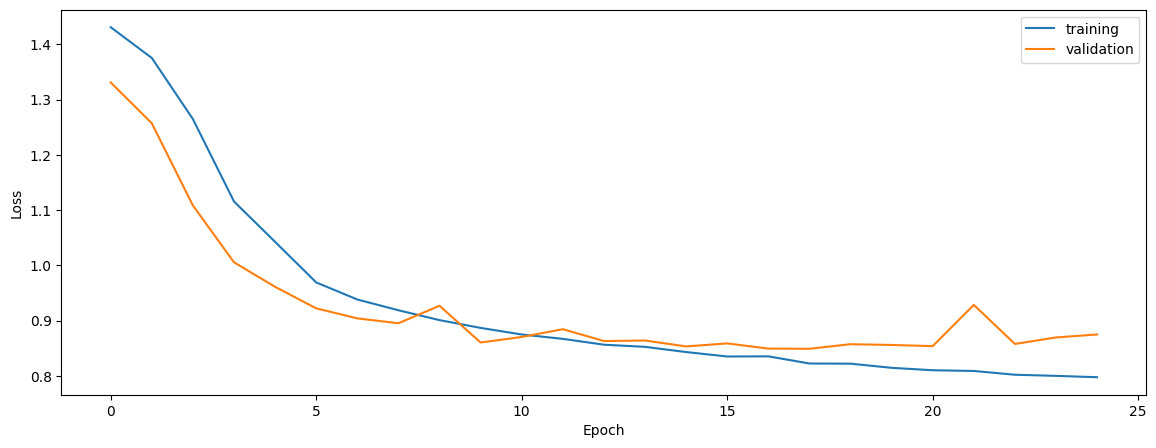

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6816362827923521
0.669441535239034
0.6460897181421199


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6816362827923521
0.669441535239034
0.6460897181421199


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6883311896512465
0.6679286732571456
0.6649267019538015


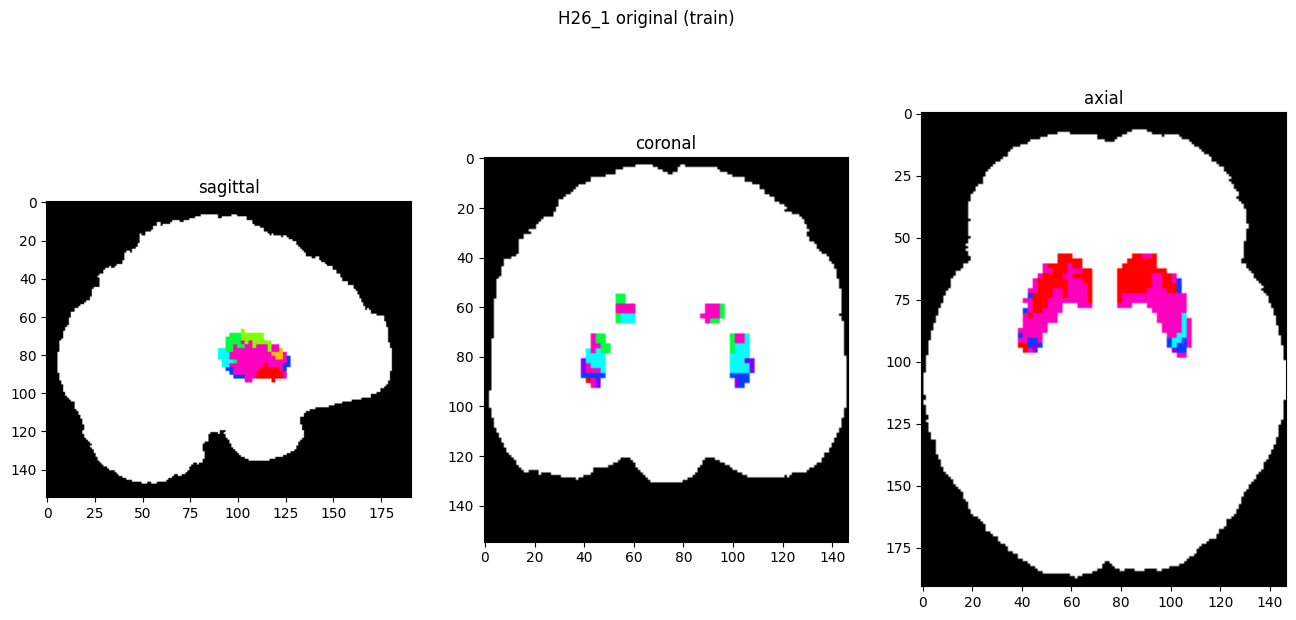

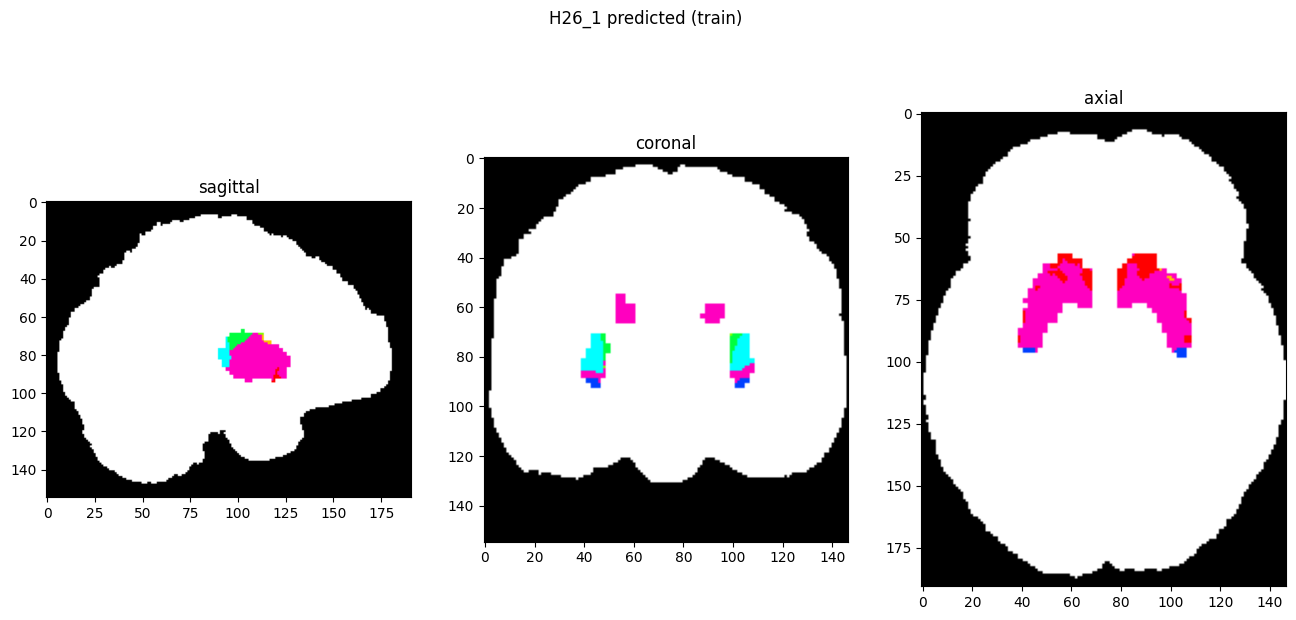

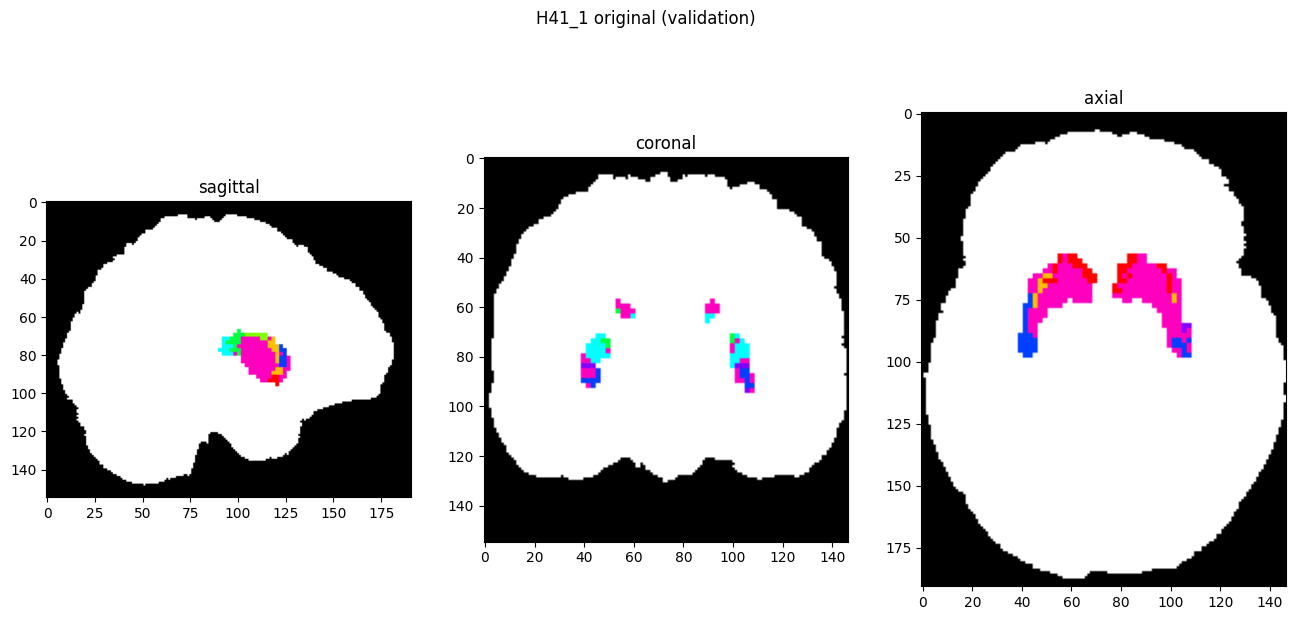

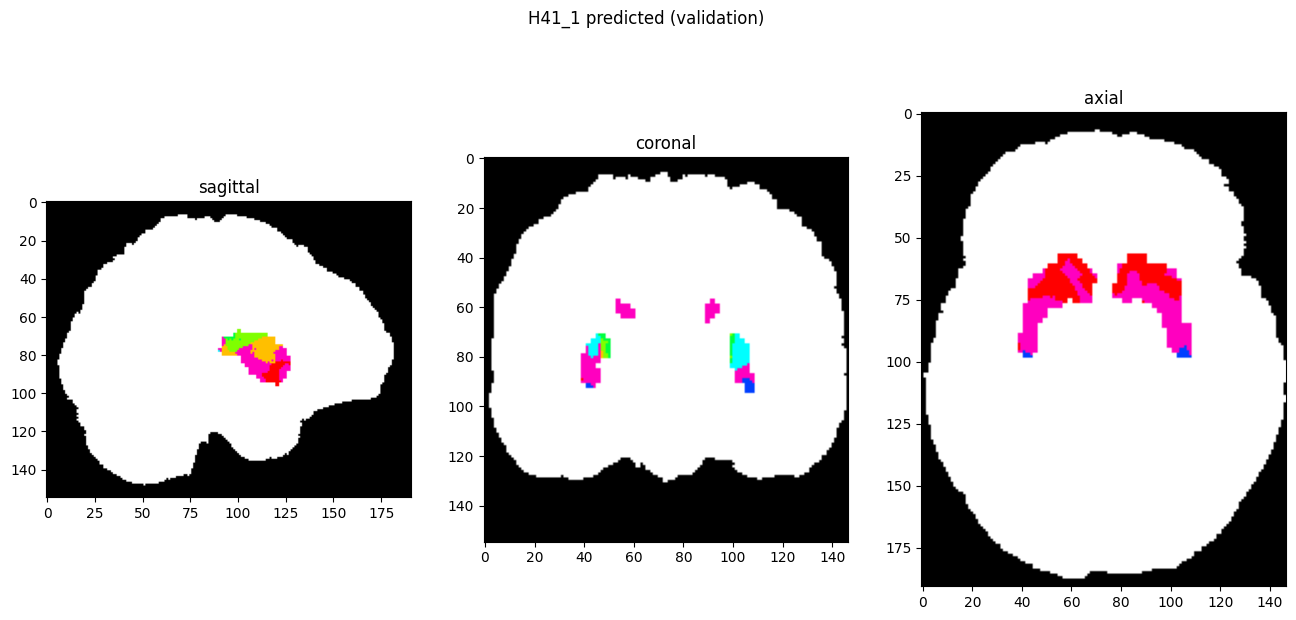

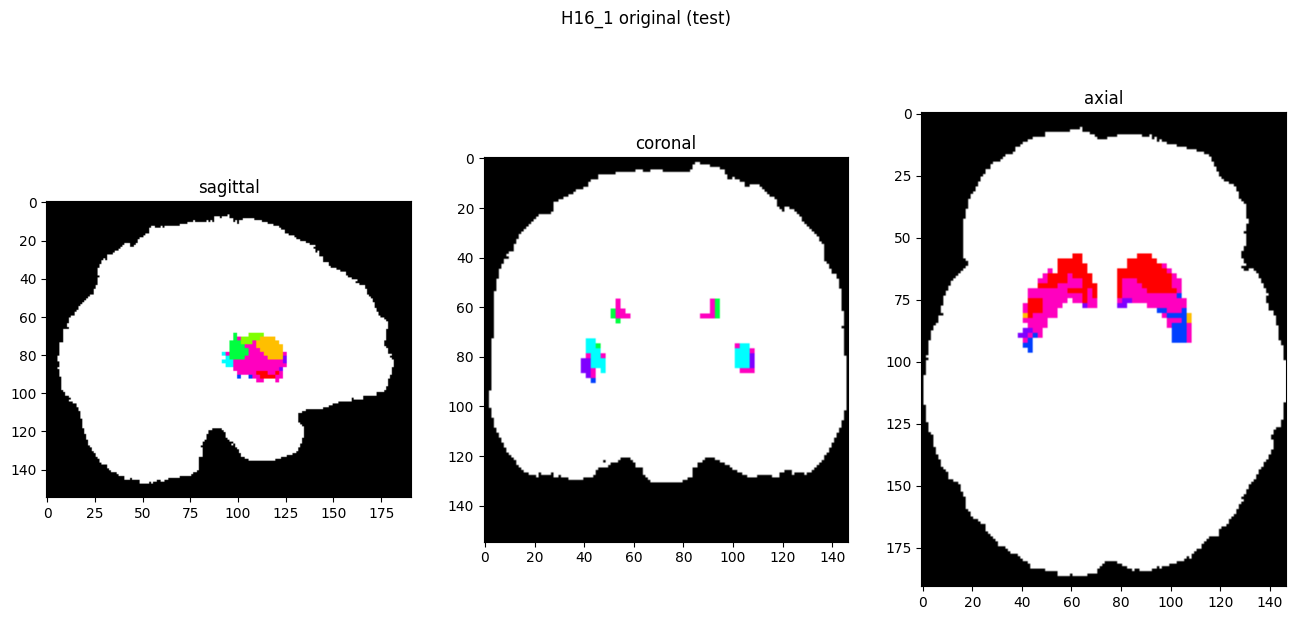

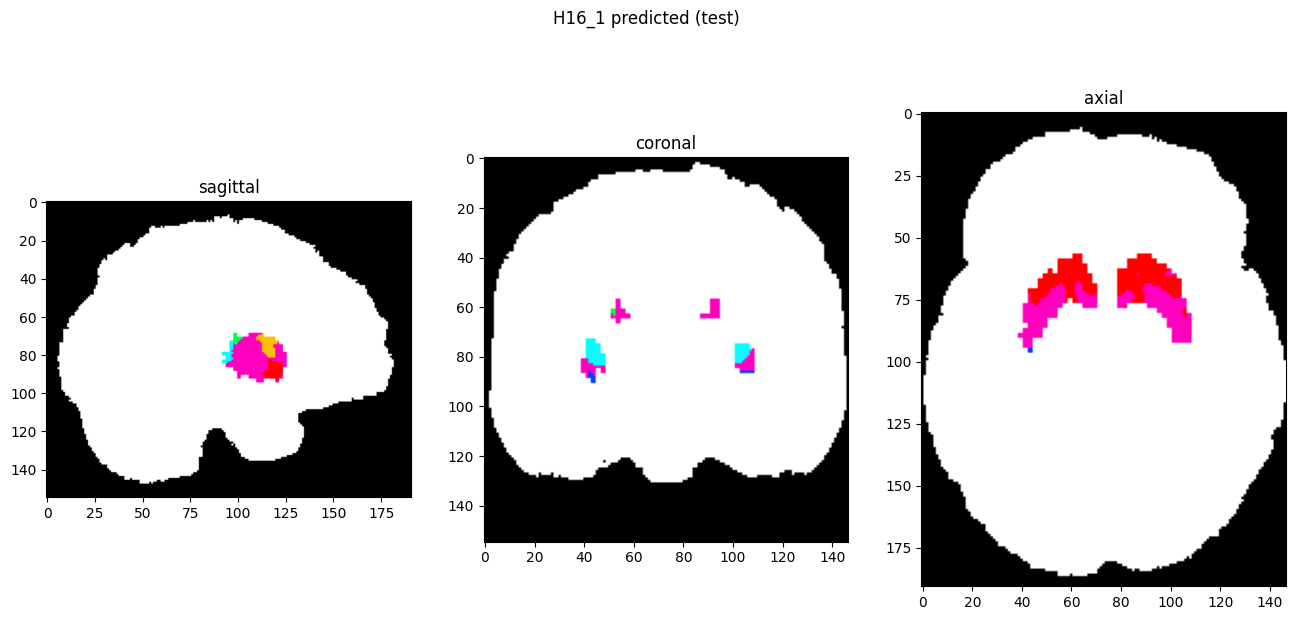

In [10]:
showResults(model, gen, threshold=0)